# Collection and Analysis of Embeddings

We visualize the names in our investigation as ADA-002 embeddings.

In [11]:
import json
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import umap
import openai
from openai import OpenAI

# Authentication for Open AI:
## Note: we've set these as environment variables.
openai.organization = os.getenv("OPENAI_ORG")
openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
# output
fn_weights_2d = '../data/output/names_embedded_for_graphic.csv'
fn_weights = '../data/intermediary/embeddings/names_embedded_ada.json'
os.makedirs('../data/intermediary/embeddings/', exist_ok=True)

# inputs
fn_names_men = '../data/input/top_mens_names.json'
fn_names_women = '../data/input/top_womens_names.json'

race2names_men = json.load(open(fn_names_men))
race2names_women = json.load(open(fn_names_women))

## Get embeddings from names

In [3]:
client = openai.OpenAI()

In [4]:
model = 'text-embedding-ada-002'
if not os.path.exists(fn_weights):
    data = []
    for i, race2name in enumerate([race2names_men, race2names_women]):
        sex = 'male' if i == 0 else 'female'
        for race, names in race2name.items():
            for name in tqdm(names):
                response = client.embeddings.create(input = [name], model=model)
                embeddings = response.model_dump()['data'][0]['embedding']
                data.append({
                    'race': race,
                    'embeddings': embeddings,
                    'name': name,
                    'sex': sex
                })
    df = pd.DataFrame(data)
    df.to_json(fn_weights, lines=True, orient='records')

else:
    df = pd.read_json(fn_weights,lines=True, orient='records')

## Run UMAP on name embeddings
Reduce thousands of dimensions into 2-dimensions

In [94]:
data = df.to_dict(orient='records')

In [95]:
embeddings = np.array([_['embeddings'] for _ in data])

In [96]:
embeddings[0]

array([-0.00474996, -0.0186778 , -0.01011714, ..., -0.02141506,
        0.01106982, -0.00347861])

In [312]:
reducer = umap.UMAP(n_components=2, random_state=400, 
                    n_neighbors=30, min_dist=.9)

In [313]:
embeddings_2D = reducer.fit_transform(embeddings)

In [314]:
df_embed = pd.DataFrame({
    'x' : embeddings_2D[:, 0],
    'y': embeddings_2D[:, 1],
    'name' : df['name'].tolist(),
    'race/eth' : df['race'].tolist()
})

In [316]:
race2color = {'W' : '#c71e1d', 'B' : '#fa8c00', 'A' : '#009076', 'H' : '#15607a', 'CTRL' : 'grey'}

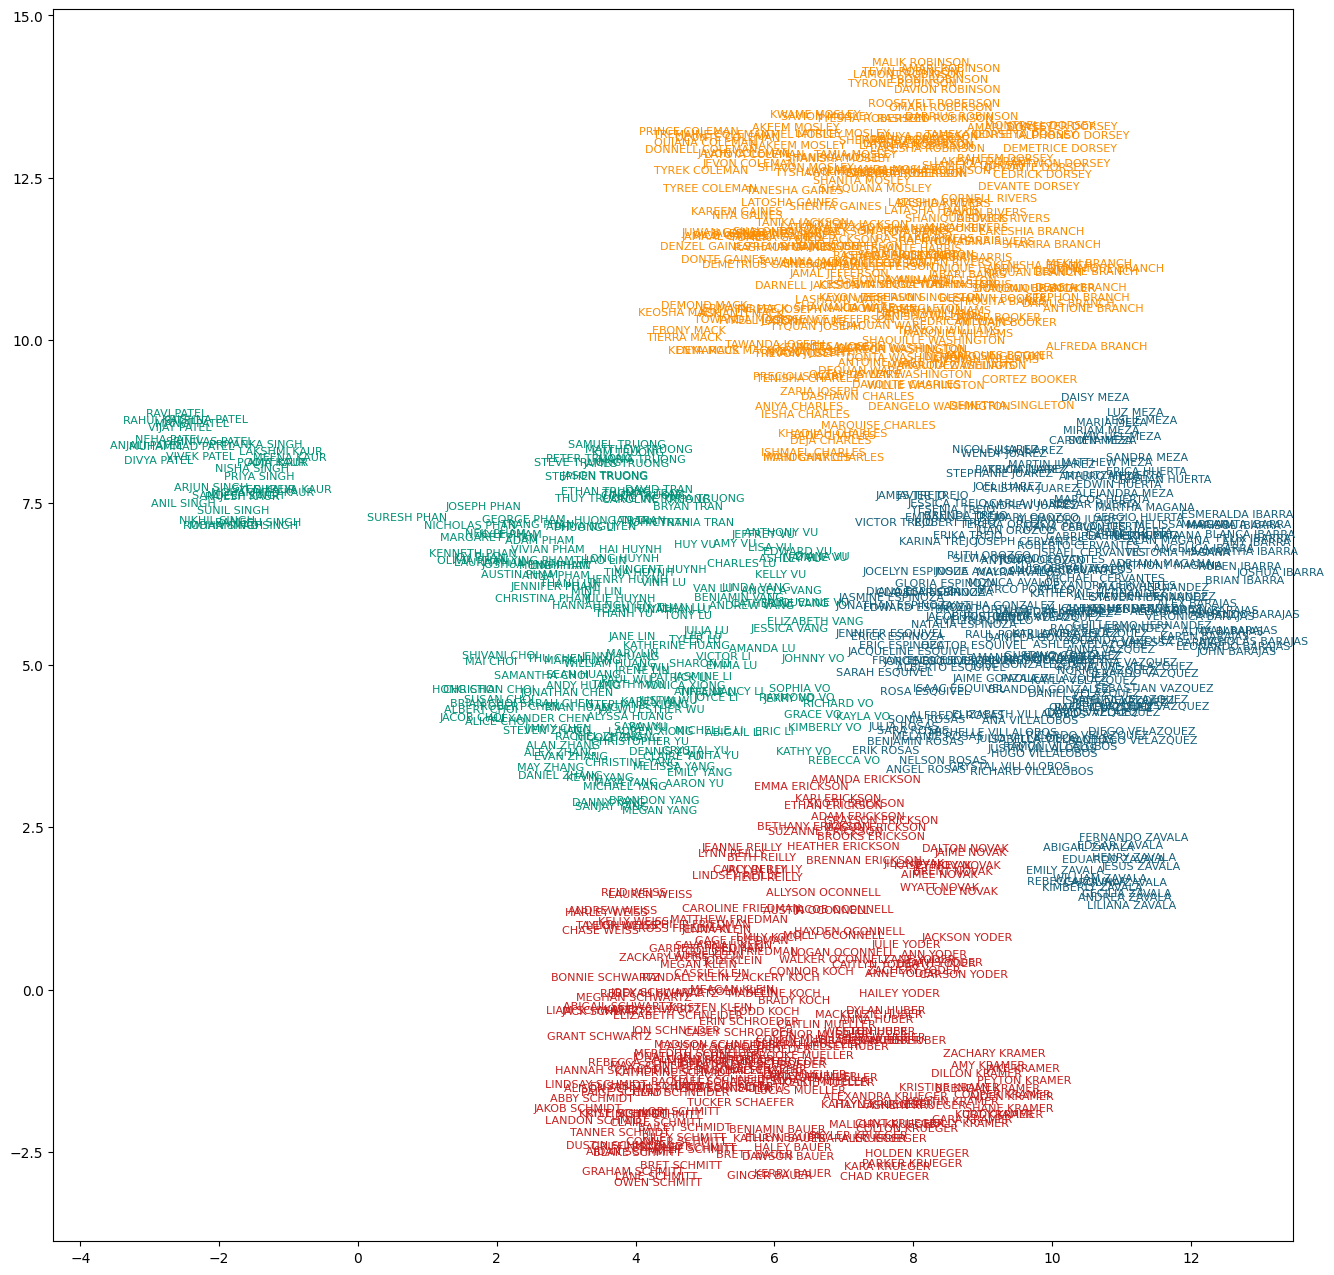

In [317]:
y = df_embed['x'].tolist()
z = df_embed['y'].tolist()
n = df_embed['name'].tolist()
c = [race2color.get(_) for _ in df_embed['race/eth'].tolist()]

fig, ax = plt.subplots(figsize=(16,16))
ax.scatter(y, z, color='white')

for i, txt in enumerate(n):
    ax.annotate(txt, (y[i], z[i]), c=c[i], size=8)

In [318]:
df_embed.to_csv(fn_weights_2d, index=False)